# Group20 Assignment 

loading the data and importing the library 

In [46]:
import sweetviz as sv

In [47]:
import pandas as pd 
import pytz
import numpy as np
import seaborn as sns

In [48]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from torchtext.data.utils import get_tokenizer

import matplotlib.pyplot as plt

import torch
from torch import nn 
import torch.nn.functional as F
from torch import utils

torch.manual_seed(0)
np.random.seed(0)

import warnings
warnings.filterwarnings("ignore")

In [49]:
train=pd.read_csv('https://raw.githubusercontent.com/zerickzhan/Group-20/main/review_train.csv')
challenge=pd.read_csv('https://raw.githubusercontent.com/zerickzhan/Group-20/main/review_challenge.csv')

## Univariate Analysis

we will use sweetviz for some quick and direct EDA to get started.

In [50]:
analyze_report = sv.analyze(train)
analyze_report.show_html('report.html')

                                             |                                             | [  0%]   00:00 ->…

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [51]:
analyze_reportchallenge = sv.analyze(challenge)
analyze_reportchallenge.show_html('challenge.html')

                                             |                                             | [  0%]   00:00 ->…

Report challenge.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [52]:
train['review_timestamp']=pd.to_datetime(train['review_timestamp'])

In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13762 entries, 0 to 13761
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   review_id                   13762 non-null  int64         
 1   user_name                   13762 non-null  object        
 2   airline_sentiment           13762 non-null  object        
 3   sentiment_confidence        13762 non-null  float64       
 4   negative_reason             8627 non-null   object        
 5   negative_reason_confidence  9889 non-null   float64       
 6   airline_name                13762 non-null  object        
 7   review_text                 13762 non-null  object        
 8   thumbup_count               13762 non-null  int64         
 9   review_coordinates          972 non-null    object        
 10  review_timestamp            13762 non-null  datetime64[ns]
 11  review_city                 9314 non-null   object    

### Duplicated values <br>
from the initial analysis we can see review_id is not a unqiue key. We want to investigate further whether these are duplicates.

In [54]:
train[train["review_id"]==570286841737318400]

,review_id,user_name,airline_sentiment,sentiment_confidence,negative_reason,negative_reason_confidence,airline_name,review_text,thumbup_count,review_coordinates,review_timestamp,review_city,user_timezone
11230,570286841737318400,djjohnpayne,negative,1.0,Cancelled Flight,0.6304,Qantas,you guys are killing me. http://t.co/iPGeIcSm,0,"[0.0, 0.0]",2015-02-24 10:19:00,"Las Vegas, NV",Pacific Time (US & Canada)
11384,570286841737318400,djjohnpayne,negative,1.0,Cancelled Flight,1.0000,Qantas,you guys are killing me. http://t.co/iPGeIcSm,0,"[0.0, 0.0]",2015-02-24 10:19:00,"Las Vegas, NV",Pacific Time (US & Canada)


In [55]:
train[train["review_id"]==570267562623152128]

,review_id,user_name,airline_sentiment,sentiment_confidence,negative_reason,negative_reason_confidence,airline_name,review_text,thumbup_count,review_coordinates,review_timestamp,review_city,user_timezone
11298,570267562623152128,alinaxkristin,negative,1.0,Flight Attendant Complaints,1.0000,Qantas,you could train your flight attendants to have...,0,NaN,2015-02-24 09:02:00,Miami,Quito
11453,570267562623152128,alinaxkristin,negative,1.0,Flight Attendant Complaints,0.6688,Qantas,you could train your flight attendants to have...,0,NaN,2015-02-24 09:02:00,Miami,Quito


from the above example we can see several values are duplicated with the only difference being the negative_reason_confidence, which made the review_id not an unique key.
Therefore, we will remove the values with lower sentiment confidence.

In [56]:
train=train.sort_values(by=['sentiment_confidence'])
train=train.drop_duplicates(subset=['review_id'], keep='last')

In [62]:
train = train.drop_duplicates(subset='review_id', keep="first")

Changed sentiment analysis from words into numeric values

<AxesSubplot:title={'center':'Histogram '}, xlabel='negative_reason_confidence', ylabel='Density'>

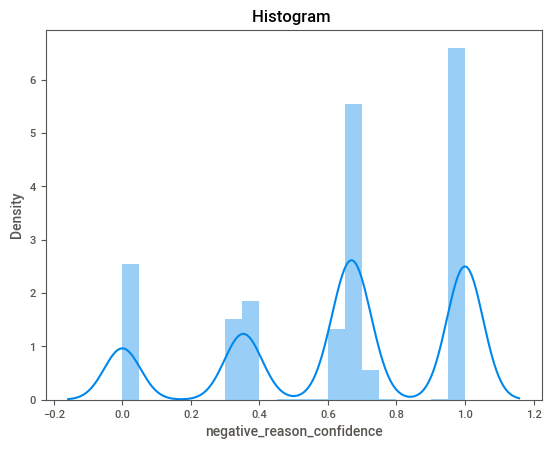

In [63]:
fig, ax = plt.subplots(1,1)
ax.set(title ="Histogram ")
sns.distplot(a=train["negative_reason_confidence"], bins=20)

<AxesSubplot:title={'center':'Histogram '}, xlabel='review_timestamp', ylabel='Density'>

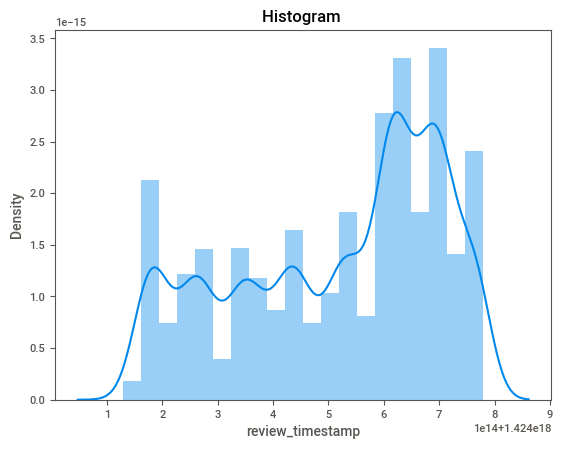

In [64]:
fig, ax = plt.subplots(1,1)
ax.set(title ="Histogram ")
sns.distplot(a=train["review_timestamp"], bins=20)

<AxesSubplot:title={'center':'Histogram '}, xlabel='sentiment_confidence', ylabel='Density'>

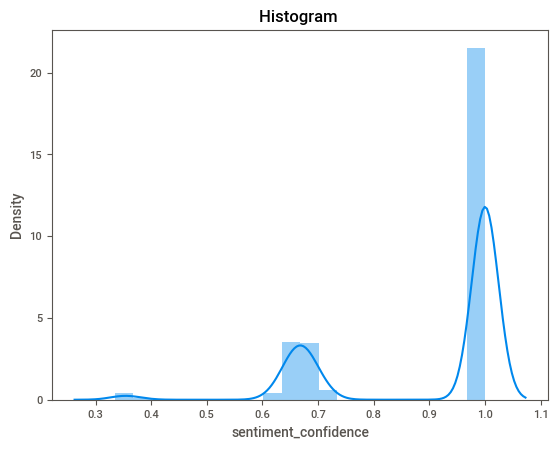

In [65]:
fig, ax = plt.subplots(1,1)
ax.set(title ="Histogram ")
sns.distplot(a=train["sentiment_confidence"], bins=20)

### Bivariate Analysis 


NameError: name 'loan' is not defined

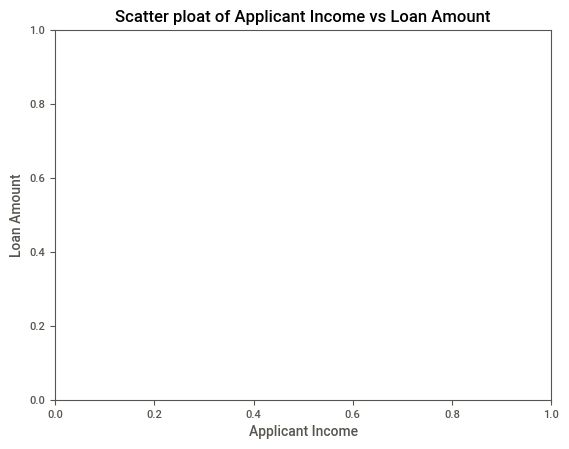

In [66]:
fig, ax = plt.subplots()
ax.set(title = "Scatter ploat of Applicant Income vs Loan Amount", xlabel="Applicant Income", ylabel="Loan Amount")
plt.scatter(x='ApplicantIncome',y='LoanAmount',data=loan)
plt.show()

Missing values

In [68]:
train['review'] = train.apply(lambda row: row['negative_reason'] if not pd.isna(row['negative_reason']) and row['negative_reason'] != '' else row['airline_sentiment'], axis=1)

In [69]:
pd.crosstab(train['airline_name'], train['review'])

review,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines,neutral,positive
airline_name,,,,,,,,,,,,
EgyptAir,18,21,17,57,4,5,27,16,3,1,155,142
Emirates,208,351,166,637,20,156,132,492,261,46,660,465
Lufthansa,82,152,149,367,13,37,60,146,87,27,623,537
Qantas,78,176,218,693,10,77,117,223,137,31,404,293
Qatar Airways,97,228,175,773,10,118,116,425,143,47,361,256
Singapore Airlines,59,172,49,181,8,58,41,255,52,14,677,508


In [70]:
filtered_data_number = train[train['user_name'].str.contains(r'\d', regex=True, na=False)]

In [71]:
train[train['review_city']=='Does it really matter']

,review_id,user_name,airline_sentiment,sentiment_confidence,negative_reason,negative_reason_confidence,airline_name,review_text,thumbup_count,review_coordinates,review_timestamp,review_city,user_timezone,review
8810,569959415433965569,ElmiraBudMan,negative,0.6702,Flight Attendant Complaints,0.6702,Qatar Airways,I get some bs from a guy at the door says door...,0,NaN,2015-02-23 12:38:00,Does it really matter,NaN,Flight Attendant Complaints
9127,569694350831161344,ElmiraBudMan,negative,0.6718,Customer Service Issue,0.6718,Qatar Airways,always nice when a customer service manager th...,0,NaN,2015-02-22 19:04:00,Does it really matter,NaN,Customer Service Issue
8771,569971542538346496,ElmiraBudMan,negative,0.6902,Can't Tell,0.6902,Qatar Airways,the exhaustion of traveling n runnin thru the ...,0,NaN,2015-02-23 13:26:00,Does it really matter,NaN,Can't Tell
8777,569970626057801728,ElmiraBudMan,neutral,0.7010,NaN,0.0000,Qatar Airways,doesn't take into account the $ it cost rent a...,0,NaN,2015-02-23 13:22:00,Does it really matter,NaN,neutral
9138,569686602940858368,ElmiraBudMan,negative,1.0000,Bad Flight,0.6596,Qatar Airways,why the hell did you overbook a plane when you...,0,NaN,2015-02-22 18:34:00,Does it really matter,NaN,Bad Flight
9150,569682545375354880,ElmiraBudMan,negative,1.0000,Late Flight,0.6632,Qatar Airways,we don't control your stupidity in not having ...,0,NaN,2015-02-22 18:17:00,Does it really matter,NaN,Late Flight
9199,569660306298945537,ElmiraBudMan,negative,1.0000,Can't Tell,1.0000,Qatar Airways,this is the reason I avoid and like the plague...,0,NaN,2015-02-22 16:49:00,Does it really matter,NaN,Can't Tell
9198,569661113593425920,ElmiraBudMan,negative,1.0000,Bad Flight,0.3481,Qatar Airways,how can a plane scheduled to come in on time a...,0,NaN,2015-02-22 16:52:00,Does it really matter,NaN,Bad Flight
9202,569659137581326336,ElmiraBudMan,negative,1.0000,Flight Attendant Complaints,1.0000,Qatar Airways,hire smarter IT people if your systems keep cr...,0,NaN,2015-02-22 16:44:00,Does it really matter,NaN,Flight Attendant Complaints
9204,569658553381883905,ElmiraBudMan,negative,1.0000,Late Flight,0.6775,Qatar Airways,what is wrong with you guys and your inability...,1,NaN,2015-02-22 16:42:00,Does it really matter,NaN,Late Flight


In [72]:
user_to_city_mapping = train[train['user_timezone'] != ''].groupby('user_name')['user_timezone'].first()

# Fill in the empty review_city values using the mapping
train['user_timezone'] = train.apply(
    lambda row: user_to_city_mapping.get(row['user_name'], row['user_timezone']),
    axis=1
)


In [73]:
train[train['user_name']=="somekidnamedjon"]

,review_id,user_name,airline_sentiment,sentiment_confidence,negative_reason,negative_reason_confidence,airline_name,review_text,thumbup_count,review_coordinates,review_timestamp,review_city,user_timezone,review
8336,567776348828360707,somekidnamedjon,positive,0.6485,NaN,NaN,Singapore Airlines,I would love for you to fly my best friend hom...,0,NaN,2015-02-17 12:03:00,✈️✈️,Eastern Time (US & Canada),positive


we need to identify spams and elimination of data that attribute nothing to the sentimente analysis:<br>
we found that news and user spams are both included in the database. 
In the mean time we also don't see much values in the timezone. As user time zone does not impact sentiment of their 
Therefore, we decide to not include that column too. 

We would also get ride off the he thumb_up data as it contains a 94% zero value.

creat a column that is a count of occurance of the user name  

In [74]:
train['user_name_count'] = train.groupby('user_name')['user_name'].transform('count')

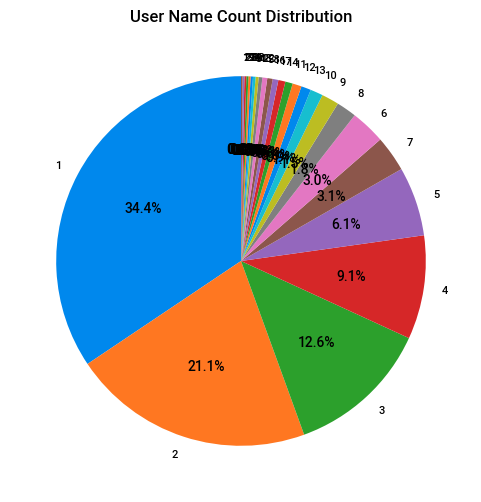

In [76]:
user_name_count = train['user_name_count'].value_counts()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(user_name_count, labels=user_name_count.index, autopct='%1.1f%%', startangle=90)
plt.title('User Name Count Distribution')
plt.show()

I want to see the distribution for airline sentiment where only user name that contained numbers are selected.

Text(0.5, 1.0, 'Airline Sentiment Distribution')

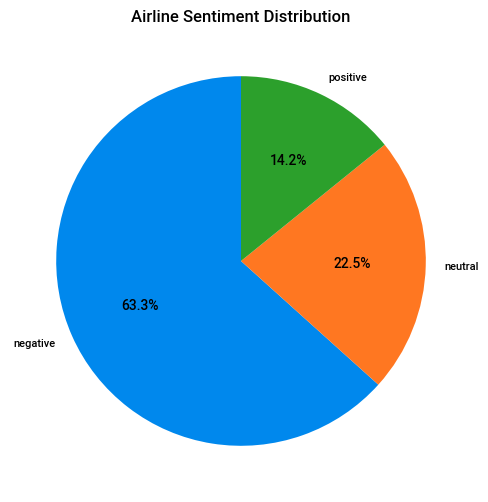

In [77]:
sentiment_counts=filtered_data_number['airline_sentiment'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Airline Sentiment Distribution')

In [78]:
user_name_counts = train['user_name'].value_counts()
filtered_df = train[train['user_name'].isin(user_name_counts[user_name_counts<6].index)]

In [79]:
count_blank = len(train[(train['user_timezone'].isna() | train['user_timezone'].eq('')) & (train['review_city'].isna() | train['review_city'].eq(''))])

print("Number of rows where both 'review_timestamp' and 'review_city' are blank:", count_blank)

Number of rows where both 'review_timestamp' and 'review_city' are blank: 2473


In [80]:
count_blank2 = len(train[
    (train['user_timezone'].isna() | train['user_timezone'].eq('')) &
    (train['review_city'].isna() | train['review_city'].eq('')) &
    (train['review_coordinates'].isna() | train['review_coordinates'].eq(''))
])

print("Number of rows where 'user_timezone', 'review_city', and 'review_coordinates' are blank:", count_blank)


Number of rows where 'user_timezone', 'review_city', and 'review_coordinates' are blank: 2473


In [81]:
debug_selection = len(train[(train['negative_reason_confidence'].isna()) & (train['airline_sentiment'] == 'negative')])
print(debug_selection)

0


as we can see, the reivew text for sentiments contain things like #Name and thanks. It would be resasonable for us to exclude those from our anlysis as

From the above EDA extracts we can see: <br>
1. The airline sentiment are separated into 3 different kinds with 63% in negative, 21% in neural, and 16% in positive.<br>
2. There are 10 negative reasons, and the top 1 accounts for 32% being: Customer service Issue.<br>
3. We can see the data is collected from 6 different airline companies, with the top 3 being Emirate (26%), Qatar Airways(20%), and Qantas (19%)<br>

<br>
The data is suffering from missing data:<br>

1. 92.24% of review coordinates are missing, we this varible is going to cause collinearity issue with review city and we decide to keep review city. <br>

2. Contrary to our believe,review city and user time zone do not share all its missing rows. Only 2499 rows are missing for both review city and review time_zone. The inclusion of review coordinate can bring this down to 2418.<br>

3. The missing values of negative_reason is caused by the airline_sentiment not being negative. we are going to create a new column called reivew and backfill " positive" or "neural" for the missing values.


Due to the frequent apperance of unformted and incorrect entries, we are unable to use review city and decide to remove that one.
Due to the huge amount of missing data for the review coordianate. we decide to remove this column too.

## Feature Engineering 

In [82]:
# preprocessing data
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() 
target = le.fit_transform(train['airline_sentiment']) # convert target into integers
train['airline_sentiment'] = target
print(le.classes_) # this shows which index maps to which class


['negative' 'neutral' 'positive']


In [83]:
np.random.seed(511365)

index = list(range(train.shape[0])) # an list of indices
np.random.shuffle(index) # shuffle the index in-place

p_val = 0.2
p_test = 0.2
N_test = int(train.shape[0] * p_test)
N_val = int(train.shape[0] * p_val)


# get training, val and test sets
test_data = train.iloc[ index[:N_test] ,:]
val_data = train.iloc[ index[N_test: (N_test+N_val)], :]
train_data = train.iloc[ index[(N_test+N_val):], :]

print(test_data.shape)
print(val_data.shape)
print(train_data.shape)

(2724, 15)
(2724, 15)
(8172, 15)


In [84]:
# define our own torch dataset
# for a torch dataset, we need to define two functions: 
#     __len__: return the length of dataset
#     __getitem__: given a index (integer), return the corresponding sample, both y and X

class SpamDataset(utils.data.Dataset):
    def __init__(self, myData):
        """
        myData should be a dataframe object containing both y (first col) and X (second col)
        """
        super().__init__()
        self.data = myData
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        return (self.data.iloc[idx,2], self.data.iloc[idx,7]) # (target, text)

In [85]:
# now we can build our torch dataset 
train_torch = SpamDataset(train_data)
val_torch = SpamDataset(val_data)
test_torch = SpamDataset(test_data)

In [86]:
tokenizer = get_tokenizer('basic_english')

In [87]:
from torchtext.vocab import build_vocab_from_iterator

# ===== Build vocabulary =====
# an unknown token is added for all unknown words outside the documents
# you may specify the min_freq to filter out infrequent words
vocabulary = build_vocab_from_iterator(
    [tokenizer(msg) for msg in train['review_text']],
    specials=["<unk>"],
    min_freq = 3, # filter out all words that appear less than three times
)
# Set to avoid errors with unknown words
vocabulary.set_default_index(vocabulary["<unk>"])

In [ ]:
# define a function that converts a document into tokens (represented by index)
def doc_tokenizer(doc):
    return torch.tensor([vocabulary[token] for token in tokenizer(doc)], dtype=torch.long)

In [88]:
# define a function that converts a document into tokens in list instead of tensor
def doc_tokenizer2(doc):
    return [vocabulary[token] for token in tokenizer(doc)]

In [89]:
# ========= Step 2 ==============
# Notice in a corpus, each document can have different size. Thus, we usually pad zeros to the maximum length of document.
# Alternatively, you can concat all documents into a long vector 
# and the starting index of each document is identified in the variable called offsets.

def collate_batch(batch):
    
    target_list, text_list, offsets = [], [], [0] # initalize the first offset to be 0 here
        
    # loop through all samples in batch
    for idx in range(len(batch)):
        
        _label = batch[idx][0]
        _text = batch[idx][1]
        
        target_list.append( _label )
        tokens = doc_tokenizer( _text )
        text_list.append(tokens)
        
        # ====== wrong ======
        #if idx == 0:
        #    offsets.append(0)  # the first document starts from idx 0
        #else:
        #    offsets.append(offsets[-1] + tokens.size(0)) # the next document starts from (offsets[-1] + tokens.size(0))
        # ===================
        
        offsets.append(offsets[-1] + tokens.size(0))
    
    offsets = offsets[:-1] # remove the last entry
    
    # convert to torch tensor
    target_list = torch.tensor(target_list, dtype=torch.int64)
    offsets = torch.tensor(offsets)
    text_list = torch.cat(text_list) # concat into a long vector
    
    return target_list, text_list, offsets

In [90]:
torch.manual_seed(0)

batchSize = 8
train_loader = utils.data.DataLoader(train_torch, batch_size=batchSize, shuffle=True, collate_fn=collate_batch)
val_loader = utils.data.DataLoader(val_torch, batch_size=batchSize, shuffle=True, collate_fn=collate_batch)
test_loader = utils.data.DataLoader(test_torch, batch_size=batchSize, shuffle=False, collate_fn=collate_batch)

In [91]:
train_sentiment= list(train_data['airline_sentiment'])
train_review_text= []
for idx in range(len(train_data['review_text'])):
    token=doc_tokenizer2( list(train_data['review_text'])[idx])
    train_review_text.append(token)


train_loader is tokenized values we processed 

Model building

In [92]:
# ====== Step 1 ========= 
class SpamClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, mode='mean') # embedding layer
        self.Linear1 = nn.Linear(embed_dim, 1)
        self.Dropout = nn.Dropout(p=0.1)
    
    def forward(self, text, offsets):
        # note we need offsets to indicate which document we have
        out = self.embedding(text, offsets)
        out = self.Dropout(out)
        out = self.Linear1(out)
        return out
        # for the last layer, we don't apply activation because we can use BCEWithLogitsLoss to combine sigmoid with BCELoss
        
# model initalization
embed_dim = 8
model = SpamClassifier(len(vocabulary), embed_dim)

In [93]:
# ======= Step 2 ==========
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [94]:
def evaluate(dataloader):
    
    y_pred = torch.tensor([]) # store prediction
    y_true = torch.tensor([]) # store true label
    
    model.eval()
    with torch.no_grad():
        for label, text, offsets in dataloader:
            y_pred_batch = model(text, offsets)
            
            y_pred = torch.cat((y_pred, y_pred_batch.squeeze()))
            y_true = torch.cat((y_true, label.squeeze()))
            
    return y_pred, y_true

In [71]:
# ======== Step 3 ==============
epochs = 300
for epoch in range(epochs):
    
    for y_train, text, offsets in train_loader:
        # zero the parameter gradients
        optimizer.zero_grad()

        # calulate output and loss 
        y_pred_train = model(text, offsets)
        loss = loss_fn(y_pred_train.squeeze(), y_train.float())

        # backprop and take a step
        loss.backward()
        optimizer.step()
    
    # evaluate on validation set
    y_pred_val, y_val = evaluate(val_loader)
    loss_val = loss_fn(y_pred_val.squeeze(), y_val.float())
    
    # note when making prediction, do add sigmoid activation
    pred_label = (torch.sigmoid(y_pred_val) > 0.5).long() # find out the class prediction
    acc = (pred_label == y_val).float().sum()/y_val.shape[0]
    
    model.train() # because when evaluating we change mode to eval mode
    
    print('Epoch {}: {:.4f} (train), {:.4f} (val), {:.4f} (val acc)'.format(epoch, loss, loss_val, acc))

Epoch 0: 0.2899 (train), -0.4224 (val), 0.5694 (val acc)
Epoch 1: 0.0001 (train), -3.0350 (val), 0.5775 (val acc)
Epoch 2: 1.0023 (train), -7.1558 (val), 0.5727 (val acc)
Epoch 3: -13.8849 (train), -12.6754 (val), 0.5624 (val acc)
Epoch 4: 35.0652 (train), -19.2193 (val), 0.5631 (val acc)
Epoch 5: 4.3165 (train), -27.0223 (val), 0.5591 (val acc)
Epoch 6: 0.0004 (train), -35.8699 (val), 0.5569 (val acc)
Epoch 7: -74.2605 (train), -45.8017 (val), 0.5540 (val acc)
Epoch 8: -248.7891 (train), -56.6917 (val), 0.5543 (val acc)
Epoch 9: -33.8463 (train), -68.8412 (val), 0.5569 (val acc)
Epoch 10: -289.0657 (train), -82.3842 (val), 0.5547 (val acc)
Epoch 11: -47.0130 (train), -96.3353 (val), 0.5573 (val acc)
Epoch 12: 47.8339 (train), -111.3066 (val), 0.5547 (val acc)
Epoch 13: -180.4846 (train), -127.4008 (val), 0.5551 (val acc)
Epoch 14: -186.3135 (train), -144.5322 (val), 0.5558 (val acc)
Epoch 15: -190.9116 (train), -163.0947 (val), 0.5569 (val acc)
Epoch 16: 33.4859 (train), -182.3635 (va

In [72]:
# prediction on test data
y_pred_test, y_true_test = evaluate(test_loader)
y_pred_test = torch.sigmoid(y_pred_test) > 0.5

print(confusion_matrix(y_true_test, y_pred_test))
print(classification_report(y_true_test, y_pred_test))

[[1107  599    0]
 [ 167  397    0]
 [  19  435    0]]
              precision    recall  f1-score   support

         0.0       0.86      0.65      0.74      1706
         1.0       0.28      0.70      0.40       564
         2.0       0.00      0.00      0.00       454

    accuracy                           0.55      2724
   macro avg       0.38      0.45      0.38      2724
weighted avg       0.59      0.55      0.54      2724



using word embedding

In [73]:
# ===== Build vocabulary =====
vocab2 = build_vocab_from_iterator(
    [tokenizer(s) for s in train],
    specials=["<unk>"]
)

vocab2.set_default_index(vocab2["<unk>"])

In [74]:
# Function to convert a sentence to BoW sequence
vocab2_len = len(vocab2)
def index2onehot(idx, n = vocab2_len):
    eye = torch.eye(vocab2_len)
    return eye[:,idx]

def stobow(s):
    token_idxs = vocab2(tokenizer(s))
    return index2onehot(token_idxs), torch.Tensor(token_idxs).long()

# Convert all training sentences
bow_sequences = []
for s in train['review_text']:
    bow_sequences.append(stobow(s)) 

In [75]:
# Model class
class RNN(nn.Module):
    def __init__(self, n_features, n_class, hidden_dim=20):
        super().__init__()
        # Model layers
        self.rnn = nn.RNN(n_features, hidden_dim)
        self.fc = nn.Linear(hidden_dim, n_class)
        
    def forward(self, x):
        rnn_o, h = self.rnn(x)
        fc_o = self.fc(rnn_o[-1, :]) 
        return fc_o

# init model
model = RNN(n_features=vocab2_len, n_class=vocab2_len)

# init loss
loss_function = nn.CrossEntropyLoss()

# init optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [205]:
max_iter = 300
seq_length = 2
loss_history = []
for epoch in range(max_iter):
    
    for i in range(len(bow_sequences)):
    
        Sent, tokens = bow_sequences[i]
        
        for j in range(Sent.shape[1]-seq_length):
            # loop over the two-grams
            X = Sent[:, j:j+seq_length] # j, j+1 words
            y = tokens[j+seq_length] # j+2 word as label
        
            optimizer.zero_grad()

            output = model(X.T) # pytorch requires input to be [Length, inputsize]
                        
            loss = loss_function(output, y)

            loss.backward()
            optimizer.step()

    # Collect loss at end of each iteration
    loss_history.append(loss.item())

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(loss_history)

Spam Classification 


In [95]:
# preprocessing data
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() 
target = le.fit_transform(train['airline_sentiment']) # convert target into integers
train['airline_sentiment'] = target
print(le.classes_) # this shows which index maps to which class

train.head()

[0 1 2]


,review_id,user_name,airline_sentiment,sentiment_confidence,negative_reason,negative_reason_confidence,airline_name,review_text,thumbup_count,review_coordinates,review_timestamp,review_city,user_timezone,review,user_name_count
930,569972097453137920,cristobalwong,1,0.3350,NaN,0.0,Emirates,"Thank you, ^JH, appreciate the prompt response...",0,NaN,2015-02-23 13:28:00,San Francisco Bay Area,None,neutral,7
5873,568092537786748928,VegasRenegade,1,0.3353,NaN,0.0,Lufthansa,All Flights lead to VEGAS BABY!,1,NaN,2015-02-18 08:59:00,The Wild Blue Yonder,Atlantic Time (Canada),neutral,1
5963,568028183267639297,CourtSnod,2,0.3356,NaN,0.0,Lufthansa,de-icing is important!,0,NaN,2015-02-18 04:44:00,Tennessee Original,Central Time (US & Canada),positive,1
7436,568993773277069312,KoolieAshSays,1,0.3363,NaN,0.0,Singapore Airlines,oh. Makes sense. My bad.,0,"[40.88529232, -73.856635]",2015-02-20 20:41:00,"ÜT: 17.9889591,-76.7712636",Pacific Time (US & Canada),neutral,1
2254,569227372223811584,zachkpearson,2,0.3366,NaN,0.0,Emirates,. Thanks. Hopefully this is easily resolved.,0,NaN,2015-02-21 12:09:00,"Portland, Oregon",Pacific Time (US & Canada),positive,1


simplified adaboost (week 11)

for each row number in train_review_text add zero values to match the shape of desired shape.

In [97]:
train_sentiment= list(train_data['airline_sentiment'])
train_review_text= []
for idx in range(len(train_data['review_text'])):
    train_token=doc_tokenizer2( list(train_data['review_text'])[idx])
    train_review_text.append(train_token)
y_train=np.array(train_sentiment)

val_sentiment= list(val_data['airline_sentiment'])
val_review_text= []
for idx in range(len(val_data['review_text'])):
    val_token=doc_tokenizer2( list(val_data['review_text'])[idx])
    val_review_text.append(val_token)
y_val=np.array(val_sentiment)

test_sentiment= list(test_data['airline_sentiment'])
test_review_text= []
for idx in range(len(test_data['review_text'])):
    test_token=doc_tokenizer2( list(test_data['review_text'])[idx])
    test_review_text.append(test_token)
y_test=np.array(test_sentiment)

In [126]:
find_max_list(train_review_text)

39

In [98]:
def find_max_list(list):
    list_len = [len(i) for i in list]
    return(max(list_len))

def zeropad(data):
    max_length = 40
    train_review_text_pad = [sublist + [0] * (max_length - len(sublist)) for sublist in data]
    zero_pad=np.array(train_review_text_pad)
    return zero_pad

In [99]:
X_train=zeropad(train_review_text)
X_val=zeropad(val_review_text)
X_test=zeropad(test_review_text)

### Gradient boost

In [ ]:
GBoost_clf= GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

### XGBoost

In [100]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [101]:
xgbst =xgb.XGBClassifier(objective='multi:softmax',
                       num_class=3,
                      eval_metric='mlogloss',
                      randomstate=42)

In [102]:
tuning_parameters={
                   'learning_rate':[0.01,0.05,0.1],
    'max_depth':[2,3,4,5,6,7],
    'n_estimators':[800,1000,1500,2000],
    'subsample':[0.60,0.80,1.0],
    'reg_lambda':[0.0,0.3,0.5,0.8]
}

In [103]:
xgbst_random = RandomizedSearchCV(xgbst, 
                                  tuning_parameters,
                                  n_iter=32,
                                  cv=5, 
                                 random_state=42,
                                 n_jobs=-1)
xgbst_random.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           min_child_weight=None, missing=nan,
                

In [104]:
print('Best parameters found by randomized search:', xgbst_random.best_params_)

Best parameters found by randomized search: {'subsample': 0.8, 'reg_lambda': 0.0, 'n_estimators': 1500, 'max_depth': 3, 'learning_rate': 0.05}


In [105]:
xgbst_update=xgb.XGBClassifier(objective='multi:softmax',
                              num_class=3,
                              eval_metric='mlogloss',
                              **xgbst_random.best_params_)
xgbst.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [106]:
xgb_y_val=xgbst.predict(X_val)

In [111]:
xgb_y_val

array([0, 0, 0, ..., 0, 0, 1])

In [110]:
y_val

array([0, 0, 0, ..., 2, 0, 1])

### Adaboost

In [135]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

weak_learner = DecisionTreeClassifier(max_leaf_nodes=8)#this is a hyper parameter and needs to be tunned
n_estimators = 300

adaboost_clf = AdaBoostClassifier(
    base_estimator=weak_learner,#Use estimator instead of base_estimator for sklearn over version 1.2 
    n_estimators=n_estimators,
    algorithm="SAMME",
    random_state=42,
).fit(X_train, y_train)
#where X_train is the number valued review text, and the y_train is the sentiment(0,1,2)

gradient boosting

In [137]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier()


def misclassification_error(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)


weak_learners_misclassification_error = misclassification_error(
    y_test, weak_learner.fit(X_train, y_train).predict(X_test)
)

dummy_classifiers_misclassification_error = misclassification_error(
    y_test, dummy_clf.fit(X_train, y_train).predict(X_test)
)

print(
    "DecisionTreeClassifier's misclassification_error: "
    f"{weak_learners_misclassification_error:.3f}"
)
print(
    "DummyClassifier's misclassification_error: "
    f"{dummy_classifiers_misclassification_error:.3f}"
)

DecisionTreeClassifier's misclassification_error: 0.350
DummyClassifier's misclassification_error: 0.374


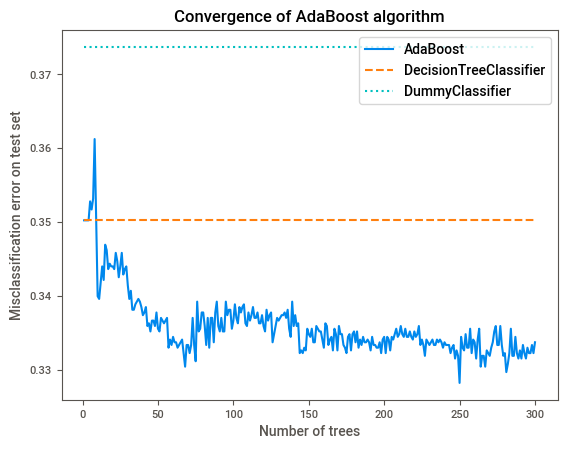

In [138]:

boosting_errors = pd.DataFrame(
    {
        "Number of trees": range(1, n_estimators + 1),
        "AdaBoost": [
            misclassification_error(y_test, y_pred)
            for y_pred in adaboost_clf.staged_predict(X_test)
        ],
    }
).set_index("Number of trees")
ax = boosting_errors.plot()
ax.set_ylabel("Misclassification error on test set")
ax.set_title("Convergence of AdaBoost algorithm")

plt.plot(
    [boosting_errors.index.min(), boosting_errors.index.max()],
    [weak_learners_misclassification_error, weak_learners_misclassification_error],
    color="tab:orange",
    linestyle="dashed",
)
plt.plot(
    [boosting_errors.index.min(), boosting_errors.index.max()],
    [
        dummy_classifiers_misclassification_error,
        dummy_classifiers_misclassification_error,
    ],
    color="c",
    linestyle="dotted",
)
plt.legend(["AdaBoost", "DecisionTreeClassifier", "DummyClassifier"], loc=1)
plt.show()

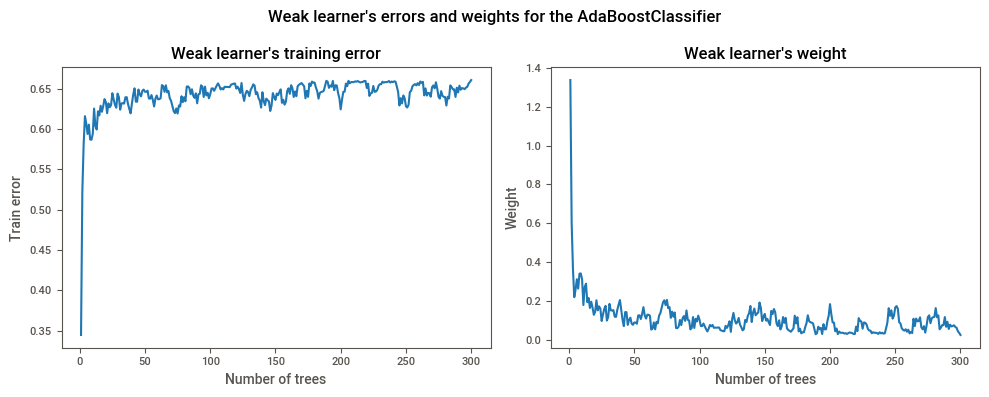

In [139]:
weak_learners_info = pd.DataFrame(
    {
        "Number of trees": range(1, n_estimators + 1),
        "Errors": adaboost_clf.estimator_errors_,
        "Weights": adaboost_clf.estimator_weights_,
    }
).set_index("Number of trees")

axs = weak_learners_info.plot(
    subplots=True, layout=(1, 2), figsize=(10, 4), legend=False, color="tab:blue"
)
axs[0, 0].set_ylabel("Train error")
axs[0, 0].set_title("Weak learner's training error")
axs[0, 1].set_ylabel("Weight")
axs[0, 1].set_title("Weak learner's weight")
fig = axs[0, 0].get_figure()
fig.suptitle("Weak learner's errors and weights for the AdaBoostClassifier")
fig.tight_layout()